Open Play Shots - Expected Goal Model - Model Evaluation - GBM

In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/")

In [6]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from expected_score_model.config import open_shots_file_path
# from total_points_model.domain.preprocessing.data_preprocessor import DataPreprocessor
# from total_points_model.domain.contracts.mappings import Mappings
from expected_score_model.domain.contracts.modelling_data_contract import ModellingDataContract
from expected_score_model.domain.modelling.supermodel import SuperXGBClassifier
from expected_score_model.domain.modelling.model_evaluation import XGBClassifierEvaluator

pd.options.display.max_rows = 200
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


New Model

In [3]:
new_version = 1
model_name = "expected_goal_open"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models"
preproc_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/preprocessors"

Comparison Model

In [4]:
old_version = new_version - 1
compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [5]:
RESPONSE = ModellingDataContract.RESPONSE_GOAL

Load Data

In [8]:
df_modelling = pd.read_csv(open_shots_file_path)
df_modelling.tail()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Goal,Behind,Score,Home_Score,Away_Score,Home_Current_Score,Away_Current_Score,Current_Margin,Event_Type0,Event_Type1,Event_Type2,Event_Type3,x0,x1,x2,x3,y0,y1,y2,y3,Quarter_Duration0,Quarter_Duration1,Quarter_Duration2,Quarter_Duration3,Chain_Duration,Time_Since_Last_Action,Distance_Since_Last_Action,Distance_to_Right_Goal_x,Distance_to_Middle_y,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Angle_to_Middle_Goal_degrees,Visible_Goal_Angle,Visible_Goal_Angle_degrees,Visible_Behind_Angle,Visible_Behind_Angle_degrees,Squared_Distance_to_Middle_Goal,Log_Distance_to_Middle_Goal,Set_Shot,random100,ModellingFilter
9211,211,kickIn,behind,1705.0,4,744,775.0,Sydney,Sydney,Tom Papley,Tom_Papley,Kick,56.0,-36.0,ineffective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,0,1,1,0,1,108.0,33.0,75.0,Kick,Gather,Kick,Handball Received,56.0,48.0,7.0,4.0,-36.0,-44.0,-47.0,-37.0,775.0,771.0,769.0,766.0,31.0,4.0,11.313708,24.0,36.0,43.266615,0.982794,56.309932,0.082503,4.727050,0.258900,14.833859,576.0,3.178054,False,56,True
9212,212,kickIn,goal,1740.0,4,787,900.0,Geelong,Geelong,Brandan Parfitt,Brandan_Parfitt,Kick,75.0,0.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,6,6,0,109.0,34.0,75.0,Kick,Handball Received,Handball,Loose Ball Get,75.0,75.0,76.0,75.0,0.0,-1.0,-5.0,-6.0,900.0,899.0,898.0,897.0,113.0,1.0,1.000000,5.0,0.0,5.000000,0.000000,0.000000,2.168022,124.218492,-1.429422,-81.899864,25.0,1.609438,False,76,True
9213,218,possGain,goal,1837.0,4,1136,1198.0,Geelong,Geelong,Sam De Koning,Sam_De_Koning,Kick,78.0,1.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,6,6,0,115.0,40.0,75.0,Kick,Gather,Kick,Handball Received,78.0,78.0,65.0,64.0,1.0,1.0,-12.0,-9.0,1198.0,1193.0,1190.0,1188.0,62.0,5.0,0.000000,2.0,1.0,2.236068,0.463648,26.565051,-2.442748,-139.959156,-0.440569,-25.242748,4.0,0.693147,False,96,False
9214,227,throwIn,goal,1901.0,4,1452,1458.0,Geelong,Geelong,Joel Selwood,Joel_Selwood,Kick,37.0,17.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,6,6,0,121.0,46.0,75.0,Kick,Gather,Knock On,Handball,37.0,37.0,43.0,34.0,17.0,19.0,20.0,25.0,1458.0,1457.0,1455.0,1453.0,6.0,1.0,2.000000,43.0,17.0,46.238512,0.376490,21.571307,0.129338,7.410516,0.403551,23.121747,1849.0,3.761200,False,98,False
9215,233,possGain,goal,1971.0,4,1744,1753.0,Sydney,Sydney,Tom Papley,Tom_Papley,Kick,48.0,-20.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,6,0,6,133.0,46.0,87.0,Kick,Bounce,Handball Received,Handball,48.0,38.0,35.0,37.0,-20.0,-31.0,-33.0,-37.0,1753.0,1752.0,1748.0,1747.0,9.0,1.0,14.866069,32.0,20.0,37.735925,0.558599,32.005383,0.144862,8.299977,0.461317,26.431498,1024.0,3.465736,False,53,True


In [9]:
training_data = df_modelling[df_modelling[ModellingDataContract.TRAIN_TEST_SPLIT_COL]]
test_data = df_modelling[~df_modelling[ModellingDataContract.TRAIN_TEST_SPLIT_COL]]

In [10]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]

In [11]:
X_test.head()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Behind,Score,Home_Score,Away_Score,Home_Current_Score,Away_Current_Score,Current_Margin,Event_Type0,Event_Type1,Event_Type2,Event_Type3,x0,x1,x2,x3,y0,y1,y2,y3,Quarter_Duration0,Quarter_Duration1,Quarter_Duration2,Quarter_Duration3,Chain_Duration,Time_Since_Last_Action,Distance_Since_Last_Action,Distance_to_Right_Goal_x,Distance_to_Middle_y,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Angle_to_Middle_Goal_degrees,Visible_Goal_Angle,Visible_Goal_Angle_degrees,Visible_Behind_Angle,Visible_Behind_Angle_degrees,Squared_Distance_to_Middle_Goal,Log_Distance_to_Middle_Goal,Set_Shot,random100,ModellingFilter
4,38,possGain,miss,392.0,1,1148,1153.0,Sydney,Sydney,Errol Gulden,Errol_Gulden,Kick,40.0,-11.0,clanger,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,0,0,0,0,18.0,9.0,9.0,Kick,Handball Received,Handball,Loose Ball Get,40.0,36.0,34.0,32.0,-11.0,-10.0,-9.0,-7.0,1153.0,1150.0,1149.0,1148.0,5.0,3.0,4.123106,38.0,11.0,39.560081,0.281772,16.144339,0.156423,8.962369,0.495369,28.382581,1444.0,3.637586,False,88,False
6,46,possGain,goal,476.0,1,1383,1389.0,Sydney,Sydney,Isaac Heeney,Isaac_Heeney,Kick,56.0,6.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,0,6,0,6,19.0,9.0,10.0,Kick,Handball Received,Handball,Handball Received,56.0,58.0,58.0,58.0,6.0,21.0,25.0,26.0,1389.0,1389.0,1388.0,1387.0,6.0,0.0,15.132746,22.0,6.0,22.803509,0.266252,15.255119,0.276208,15.825576,0.987285,56.567262,484.0,3.091042,False,96,False
15,123,centreBounce,goal,1086.0,3,128,143.0,Brisbane Lions,Brisbane Lions,Zac Bailey,Zac_Bailey,Kick,32.0,8.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,0,6,6,0,51.0,58.0,-7.0,Kick,Handball Received,Handball,Gather,32.0,22.0,26.0,26.0,8.0,18.0,20.0,20.0,143.0,140.0,139.0,139.0,15.0,3.0,14.142136,46.0,8.0,46.690470,0.172191,9.865807,0.135683,7.774075,0.423021,24.237313,2116.0,3.828641,False,94,False
17,152,possGain,goal,1351.0,3,1224,1238.0,Sydney,Sydney,Logan McDonald,Logan_McDonald,Kick,75.0,0.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,0,6,0,6,58.0,77.0,-19.0,Kick,Handball Received,Handball,Uncontested Mark,75.0,74.0,67.0,62.0,0.0,-1.0,-2.0,-2.0,1238.0,1238.0,1236.0,1235.0,14.0,0.0,1.414214,3.0,0.0,3.000000,0.000000,0.000000,-15.483871,-887.160457,-0.692641,-39.685388,9.0,1.098612,False,83,False
23,185,throwIn,miss,1611.0,4,279,315.0,Brisbane Lions,Brisbane Lions,Joe Daniher,Joe_Daniher,Kick,37.0,21.0,clanger,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,0,0,0,0,65.0,107.0,-42.0,Kick,Loose Ball Get,Kick Inside 50 Result,Kick Into F50,37.0,37.0,41.0,-6.0,21.0,24.0,29.0,43.0,315.0,314.0,306.0,305.0,36.0,1.0,3.000000,41.0,21.0,46.065171,0.473356,27.121303,0.124257,7.119376,0.387814,22.220095,1681.0,3.713572,False,98,False


Preprocess Data

In [12]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train_preproc = preprocessor.transform(X_train)
# X_test_preproc = preprocessor.transform(X_test)

In [13]:
X_train_preproc = X_train[ModellingDataContract.modelling_feature_list]
X_test_preproc = X_test[ModellingDataContract.modelling_feature_list]

In [14]:
X_train_preproc.shape, X_test_preproc.shape

((7353, 2), (1863, 2))

In [15]:
X_train_preproc.head()

,Distance_to_Middle_Goal,Angle_to_Middle_Goal
0,56.080300,0.383818
1,47.010637,0.416065
2,36.878178,0.708626
3,46.486557,0.328553
5,59.682493,0.546167


In [16]:
X_test_preproc.head()

,Distance_to_Middle_Goal,Angle_to_Middle_Goal
4,39.560081,0.281772
6,22.803509,0.266252
15,46.690470,0.172191
17,3.000000,0.000000
23,46.065171,0.473356


Load Model

In [17]:
xgb_model = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

Get Predictions

In [18]:
train_preds = xgb_model.predict(X_train_preproc)
test_preds = xgb_model.predict(X_test_preproc)

In [19]:
train_probas = xgb_model.predict_proba(X_train_preproc)[:, 1]
test_probas = xgb_model.predict_proba(X_test_preproc)[:, 1]

Compare Model

In [20]:
# compare_train_data = pd.read_csv(compare_train_predictions_file_path)
# compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [21]:
# compare_train_data = compare_train_data.rename(columns = {'xgb_preds':'old_preds',
#                                                           'xgb_probas':'old_probas'})
# compare_test_data = compare_test_data.rename(columns = {'xgb_preds':'old_preds',
#                                                         'xgb_probas':'old_probas'})


In [22]:
# training_data = pd.merge(training_data, compare_train_data, how = "left", on = ["Match_ID", "Chain_Number"])
# test_data = pd.merge(test_data, compare_test_data, how = "left", on = ["Match_ID", "Chain_Number"])

In [23]:
# training_data.tail()

Evaluate Model

In [24]:
training_data['xgb_preds'] = train_preds
training_data['xgb_probas'] = train_probas

train_xgb_evals = XGBClassifierEvaluator(model = xgb_model,
                                       data = training_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_probas",
                                       expected_label_name = "xgb_preds",
                                       # compare_name='old_probas'
                                       # compare_label_name="old_preds"
                                       )

In [25]:
test_data['xgb_preds'] = test_preds
test_data['xgb_probas'] = test_probas

test_xgb_evals = XGBClassifierEvaluator(model = xgb_model,
                                       data = test_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_probas",
                                       expected_label_name = "xgb_preds",
                                       # compare_name = "old_preds",
                                       # compare_label_name="old_preds"
                                       )

Model Averages

In [26]:
train_xgb_evals.data[[RESPONSE, 'xgb_probas']].describe()

,Goal,xgb_probas
count,7353.000000,7353.000000
mean,0.418061,0.420133
std,0.493274,0.151988
min,0.000000,0.114863
25%,0.000000,0.314697
50%,0.000000,0.390183
75%,1.000000,0.495419
max,1.000000,0.868129


In [27]:
test_xgb_evals.data[[RESPONSE, 'xgb_probas']].describe()

,Goal,xgb_probas
count,1863.000000,1863.000000
mean,0.426194,0.426757
std,0.494655,0.152102
min,0.000000,0.114863
25%,0.000000,0.324478
50%,0.000000,0.392460
75%,1.000000,0.495526
max,1.000000,0.868129


Plots

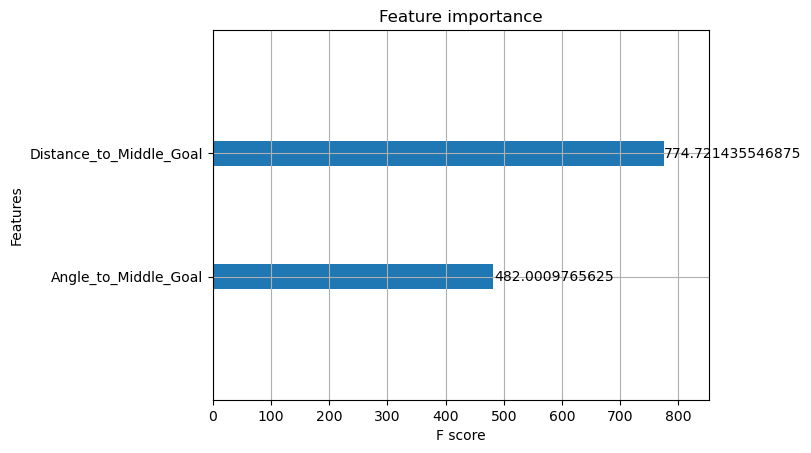

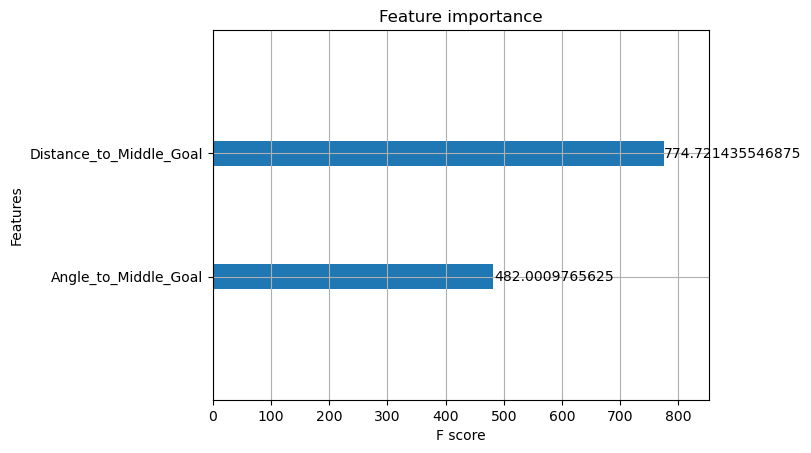

In [28]:
train_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")
test_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

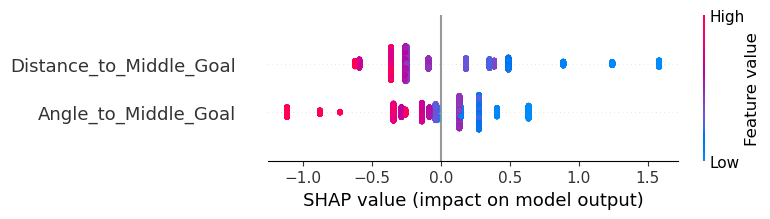

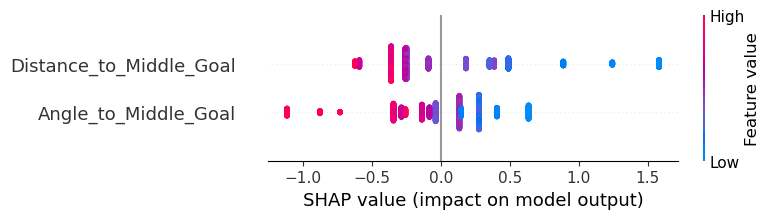

In [29]:
train_xgb_evals.plot_shap_summary_plot()
test_xgb_evals.plot_shap_summary_plot()

In [30]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['Distance_to_Middle_Goal', 'Angle_to_Middle_Goal']

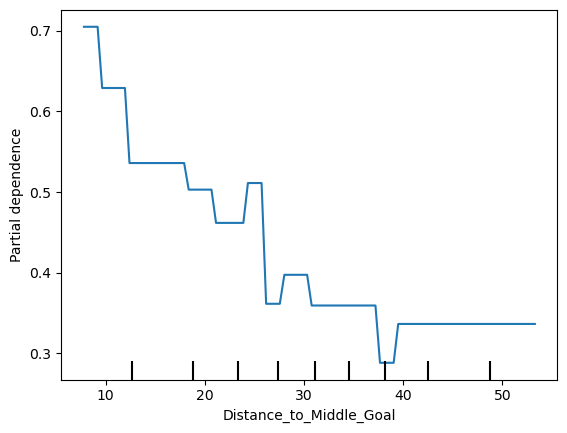

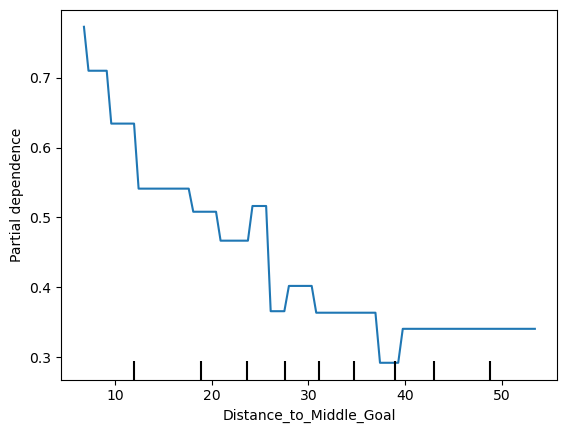

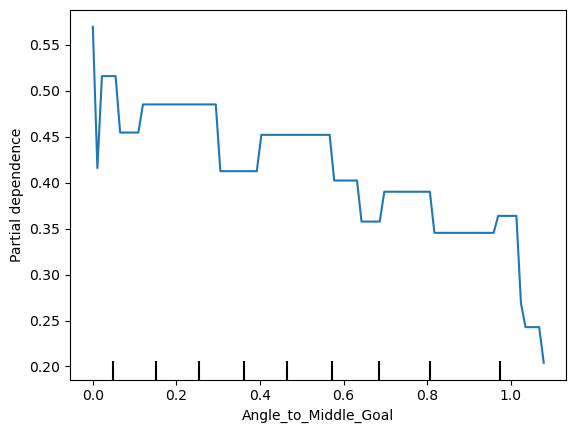

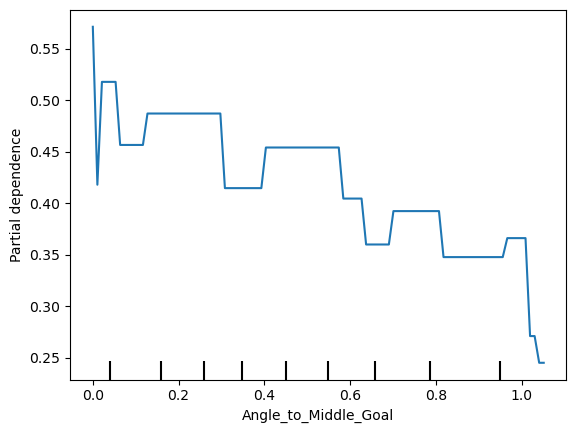

In [31]:
for col in top_10_features:
    train_xgb_evals.plot_pdp([col])
    test_xgb_evals.plot_pdp([col])

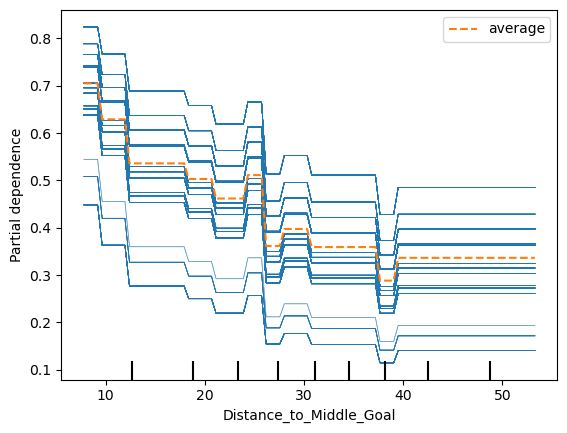

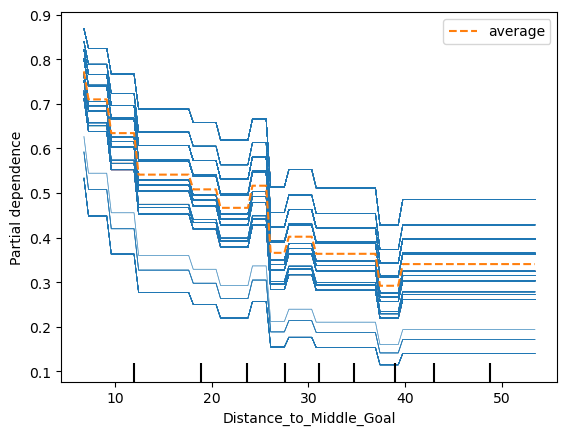

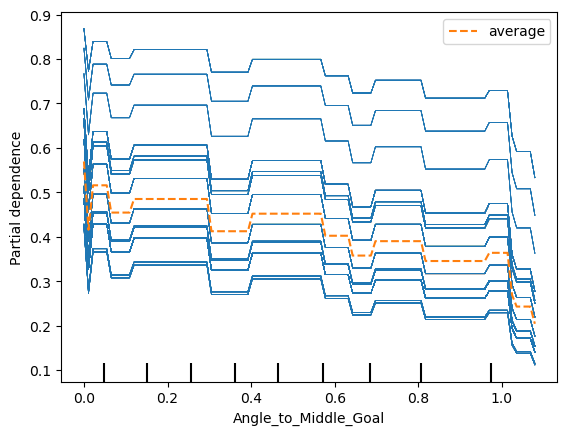

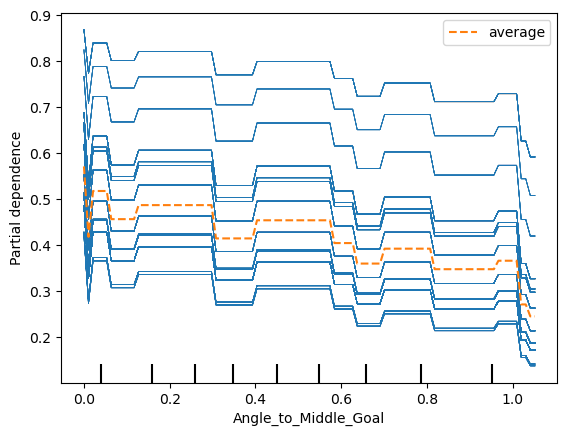

In [32]:
for col in top_10_features:
    train_xgb_evals.plot_ice([col])
    test_xgb_evals.plot_ice([col])

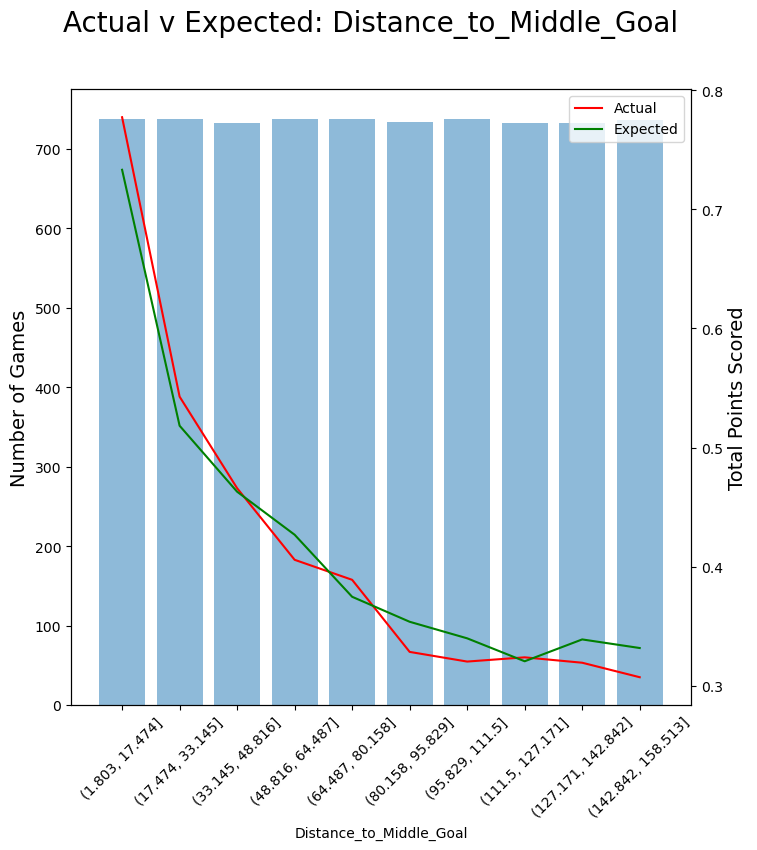

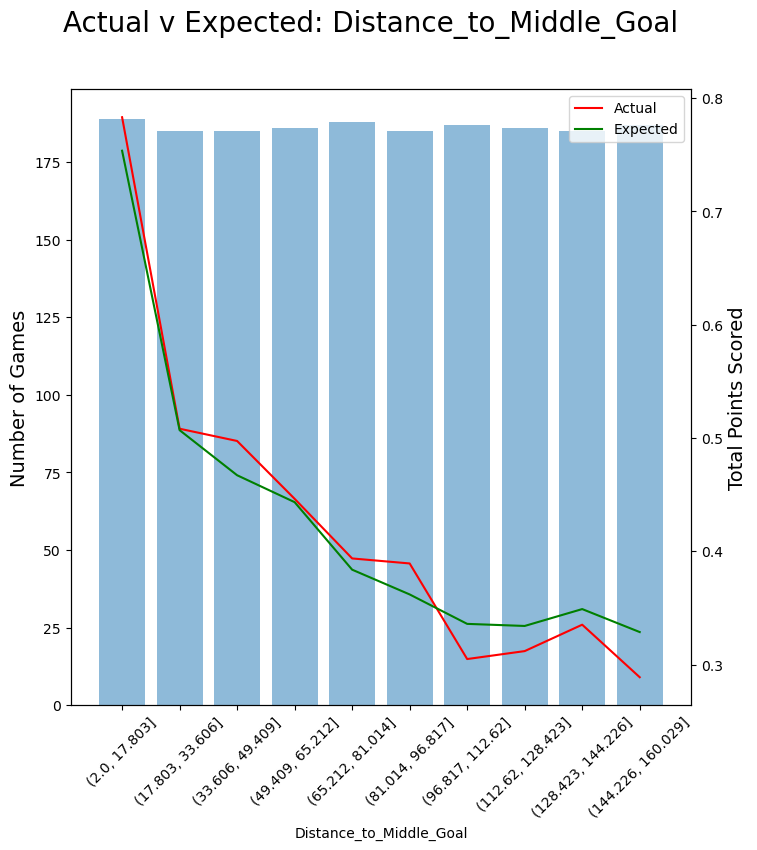

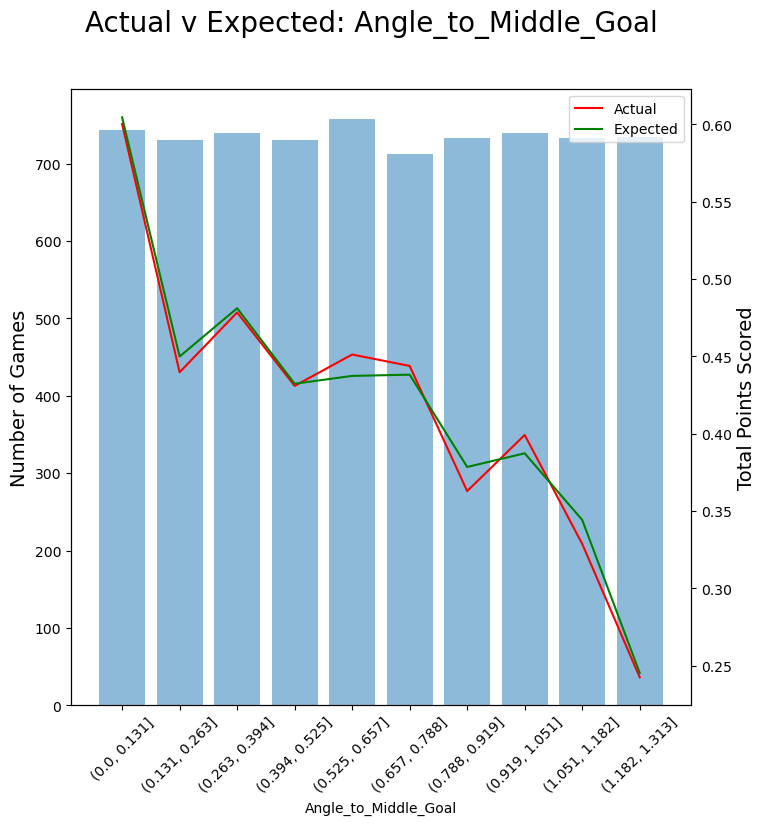

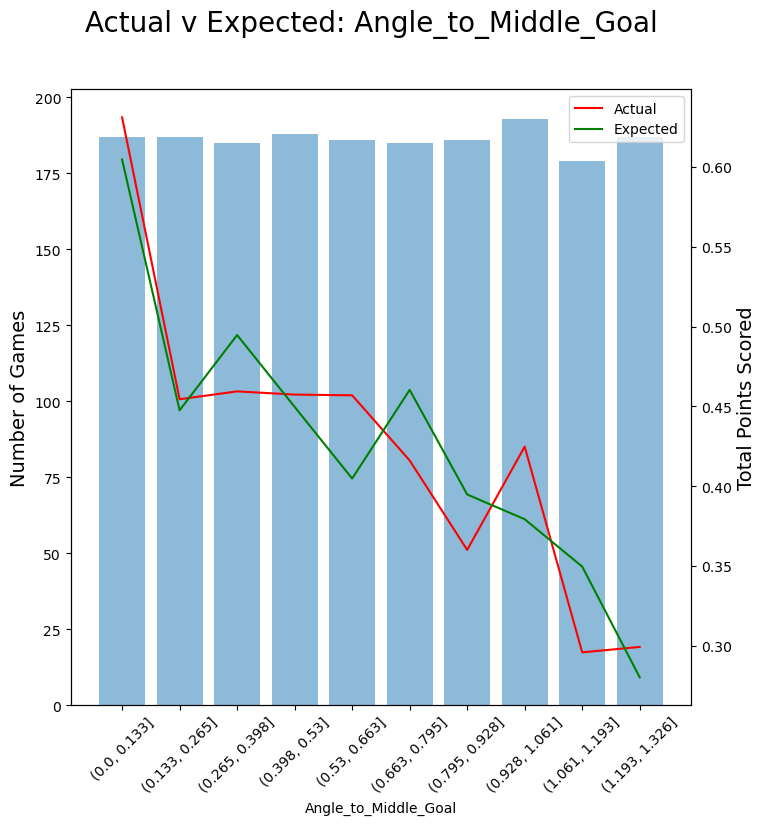

In [33]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [34]:
train_xgb_evals.get_log_loss(), test_xgb_evals.get_log_loss()

(0.6189846584492806, 0.6277071408289084)

In [35]:
train_xgb_evals.get_brier_score_loss(), test_xgb_evals.get_brier_score_loss()

(0.2150534670484496, 0.2190784301983728)

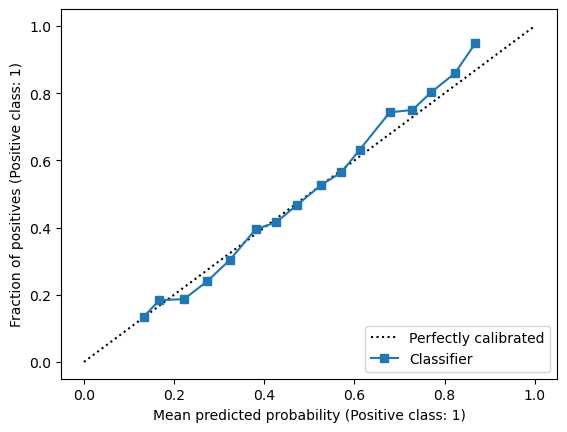

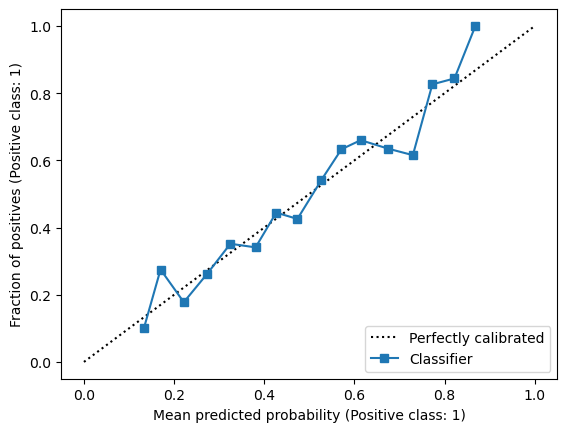

In [36]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)

In [37]:
train_xgb_evals.get_auc_score(), test_xgb_evals.get_auc_score()

(0.6190162408202259, 0.6215824719069354)

In [38]:
train_xgb_evals.get_confusion_matrix(), test_xgb_evals.get_confusion_matrix()

(array([[3687,  592],
        [1917, 1157]]),
 array([[921, 148],
        [491, 303]]))

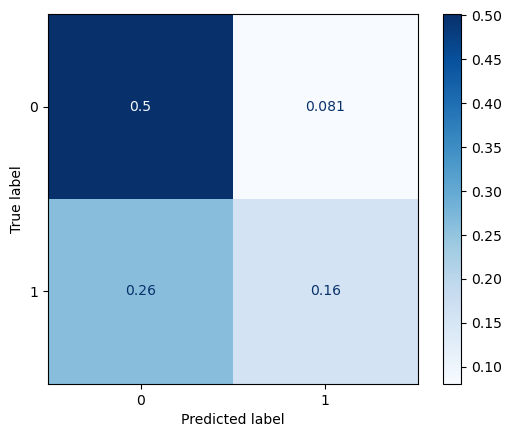

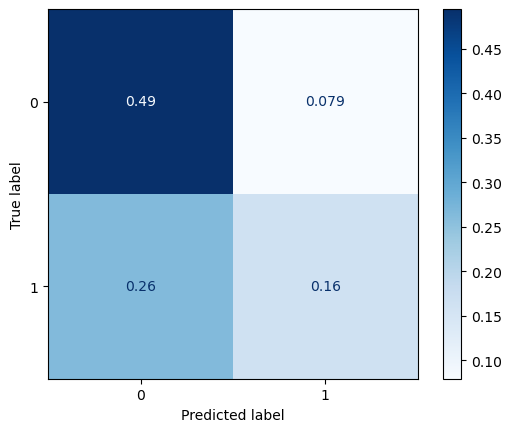

In [39]:
train_xgb_evals.display_confusion_matrix()
test_xgb_evals.display_confusion_matrix()

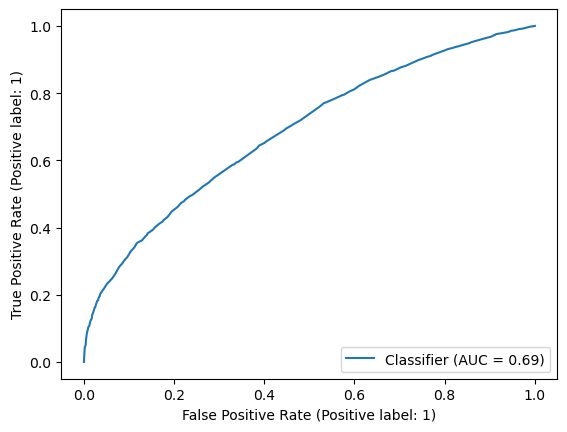

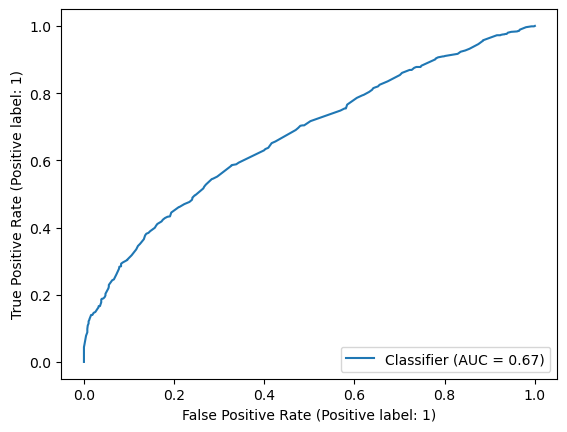

In [40]:
train_xgb_evals.plot_roc_curve()
test_xgb_evals.plot_roc_curve()

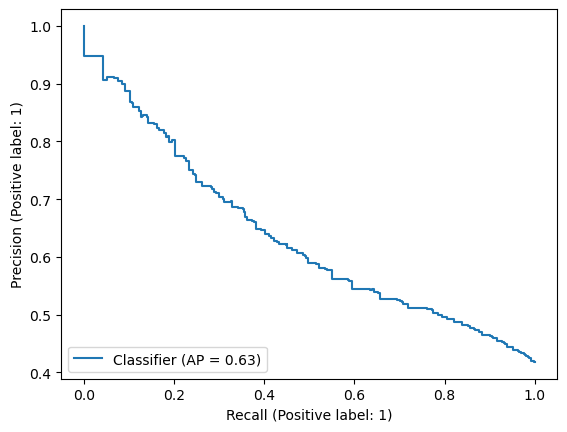

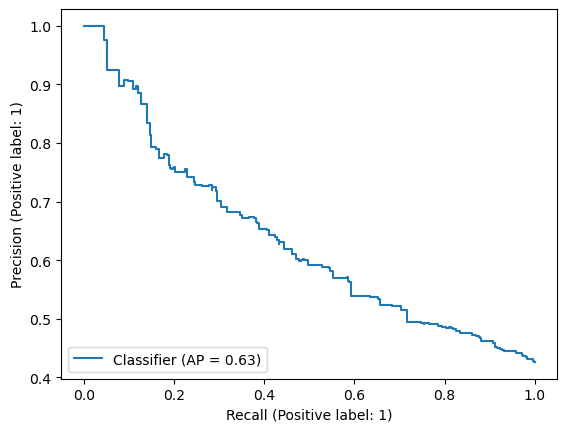

In [41]:
train_xgb_evals.plot_prauc_curve()
test_xgb_evals.plot_prauc_curve()

In [42]:
train_xgb_evals.get_accuracy(), test_xgb_evals.get_accuracy()

(0.6587787297701618, 0.6570048309178744)

In [43]:
train_xgb_evals.get_recall(), test_xgb_evals.get_recall()

(0.3763825634352635, 0.38161209068010077)

In [44]:
train_xgb_evals.get_precision(), test_xgb_evals.get_precision()

(0.6615208690680389, 0.6718403547671841)

In [45]:
train_xgb_evals.get_f1_score(), test_xgb_evals.get_f1_score()

(0.4797843665768194, 0.4867469879518072)